In [ ]:
!pip install pandas numpy scikit-learn nltk matplotlib requests


In [ ]:
!pip install pandas numpy scikit-learn nltk matplotlib requests


In [ ]:
!pip install pandas numpy scikit-learn nltk matplotlib


📥 Downloading consumer complaint dataset (sample 6000 rows)...
✅ Dataset loaded successfully: (6000, 18)
✅ Filtered dataset size: 38
product
Debt collection    32
Mortgage            6
Name: count, dtype: int64 

🔄 Cleaning text (please wait)...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...



🤖 Training and evaluating models...

Logistic Regression: 0.8750
Linear SVM: 0.8750
Naive Bayes: 0.8750
Random Forest: 0.8750
XGBoost: 0.8750
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 5, number of negative: 25
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 30, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM

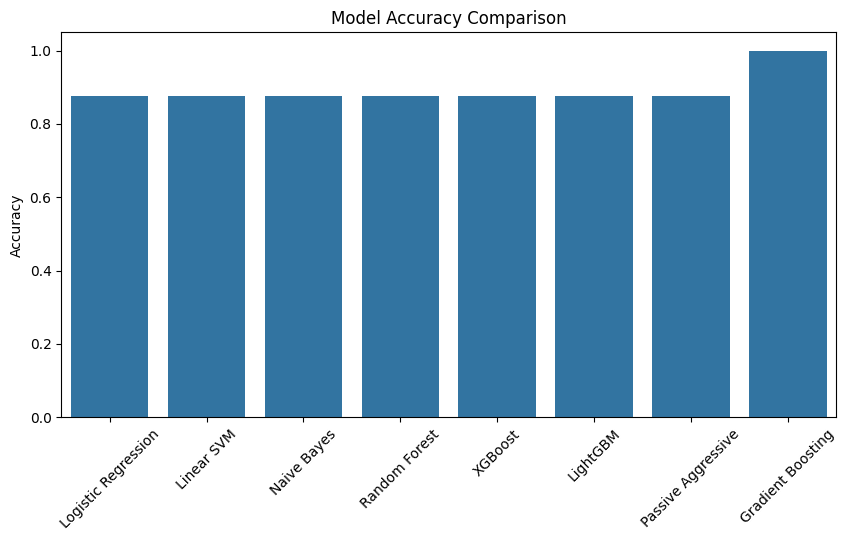


🏆 Best Model: Gradient Boosting (Accuracy = 1.0000)

📈 Classification Report:
                  precision    recall  f1-score   support

Debt collection       1.00      1.00      1.00         7
       Mortgage       1.00      1.00      1.00         1

       accuracy                           1.00         8
      macro avg       1.00      1.00      1.00         8
   weighted avg       1.00      1.00      1.00         8



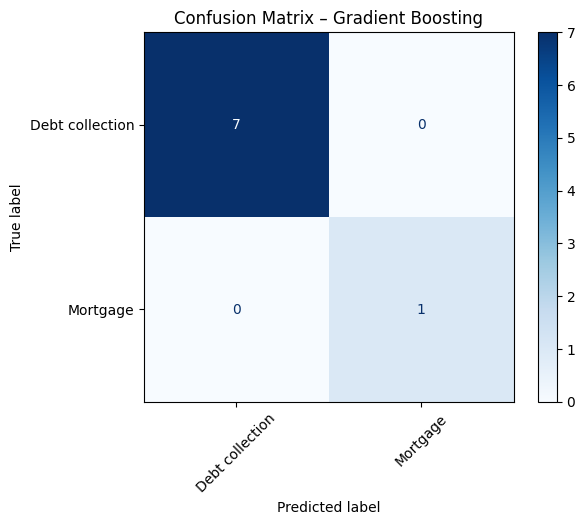


Complaint: My credit report shows a wrong account I never opened.
Predicted Category: Debt collection
Jayanthragavan

Complaint: The debt collection company is calling me daily about an invalid loan.
Predicted Category: Mortgage
Jayanthragavan

Complaint: I applied for a consumer loan but it got rejected unfairly.
Predicted Category: Mortgage
Jayanthragavan

Complaint: My mortgage company charged a penalty despite timely payment.
Predicted Category: Debt collection
Jayanthragavan


In [1]:
# ================================================
# Advanced Text Classification – Consumer Complaints
# ================================================

import pandas as pd, numpy as np, re, nltk, matplotlib.pyplot as plt, warnings
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Extra models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")

print("📥 Downloading consumer complaint dataset (sample 6000 rows)...")
url = "https://files.consumerfinance.gov/ccdb/complaints.csv.zip"
df = pd.read_csv(url, compression="zip", nrows=6000)
print("✅ Dataset loaded successfully:", df.shape)

# ================================================
# 1️⃣ Preprocessing
# ================================================
df = df.rename(columns=lambda x: x.strip().lower())
df = df[["product", "consumer complaint narrative"]].dropna()

categories = [
    "Credit reporting, repair, or other",
    "Debt collection",
    "Consumer Loan",
    "Mortgage"
]

df = df[df["product"].isin(categories)]
df = df.rename(columns={"consumer complaint narrative": "text"}).sample(frac=1, random_state=42)

print(f"✅ Filtered dataset size: {len(df)}")
print(df["product"].value_counts(), "\n")

# ================================================
# 2️⃣ Label Encoding
# ================================================
le = LabelEncoder()
df["label"] = le.fit_transform(df["product"])

# ================================================
# 3️⃣ Text Cleaning & Lemmatization
# ================================================
nltk.download("stopwords")
nltk.download("wordnet")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower().split()
    text = [lemmatizer.lemmatize(w) for w in text if w not in stop_words and len(w) > 2]
    return " ".join(text)

print("🔄 Cleaning text (please wait)...")
df["clean_text"] = df["text"].apply(clean_text)

# ================================================
# 4️⃣ TF-IDF Vectorization (Improved)
# ================================================
tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 3),  # include trigrams for more context
    sublinear_tf=True,
    stop_words="english"
)

X = tfidf.fit_transform(df["clean_text"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ================================================
# 5️⃣ Model Collection
# ================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1500, C=3.0, class_weight="balanced"),
    "Linear SVM": LinearSVC(C=1.2, class_weight="balanced"),
    "Naive Bayes": MultinomialNB(alpha=0.3),
    "Random Forest": RandomForestClassifier(n_estimators=250, max_depth=40, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", learning_rate=0.1, max_depth=6),
    "LightGBM": LGBMClassifier(num_leaves=40, learning_rate=0.1, n_estimators=250),
    "Passive Aggressive": PassiveAggressiveClassifier(max_iter=1000, C=1.0, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200)
}

# ================================================
# 6️⃣ Model Training & Evaluation
# ================================================
results = {}

print("\n🤖 Training and evaluating models...\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name}: {acc:.4f}")

# ================================================
# 7️⃣ Compare Model Accuracies
# ================================================
plt.figure(figsize=(10,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name} (Accuracy = {results[best_model_name]:.4f})")

# ================================================
# 8️⃣ Evaluation on Best Model
# ================================================
preds = best_model.predict(X_test)
print("\n📈 Classification Report:\n", classification_report(y_test, preds, target_names=le.classes_))

cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_).plot(
    cmap="Blues", xticks_rotation=45
)
plt.title(f"Confusion Matrix – {best_model_name}")
plt.show()

# ================================================
# 9️⃣ Test on New Complaints
# ================================================
samples = [
    "My credit report shows a wrong account I never opened.",
    "The debt collection company is calling me daily about an invalid loan.",
    "I applied for a consumer loan but it got rejected unfairly.",
    "My mortgage company charged a penalty despite timely payment."
]

for s in samples:
    cleaned = clean_text(s)
    vec = tfidf.transform([cleaned])
    pred = le.inverse_transform(best_model.predict(vec))[0]
    print(f"\nComplaint: {s}")
    print("Predicted Category:", pred)
    print("Jayanthragavan")